In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/intel-image-classification/seg_train/seg_train/mountain/14986.jpg
/kaggle/input/intel-image-classification/seg_train/seg_train/mountain/3138.jpg
/kaggle/input/intel-image-classification/seg_train/seg_train/mountain/1700.jpg
/kaggle/input/intel-image-classification/seg_train/seg_train/mountain/16257.jpg
/kaggle/input/intel-image-classification/seg_train/seg_train/mountain/2863.jpg
/kaggle/input/intel-image-classification/seg_train/seg_train/mountain/771.jpg
/kaggle/input/intel-image-classification/seg_train/seg_train/mountain/12167.jpg
/kaggle/input/intel-image-classification/seg_train/seg_train/mountain/17643.jpg
/kaggle/input/intel-image-classification/seg_train/seg_train/mountain/6560.jpg
/kaggle/input/intel-image-classification/seg_train/seg_train/mountain/10162.jpg
/kaggle/input/intel-image-classification/seg_train/seg_train/mountain/4009.jpg
/kaggle/input/intel-image-classification/seg_train/seg_train/mountain/15823.jpg
/kaggle/input/intel-image-classification/seg_tr

# **AKBANK BOOTCAMP PROJESİ: INTEL GÖRÜNTÜ SINIFLANDIRMA**  
Kütüphanelerin Yüklenmesi
Bu başlangıç hücresinde, projemiz için gerekli olan tüm Python kütüphanelerini (TensorFlow, Keras, NumPy, Matplotlib vb.) yüklüyoruz. Ayrıca, Kaggle'da bulunan Intel Görüntü Sınıflandırma veri setine ait dizin yollarını ve temel parametreleri (görüntü boyutu, batch boyutu) tanımlıyoruz.

In [2]:
import os
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, Lambda
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import warnings
import random
!pip install -q keras-tuner
import keras_tuner as kt
%matplotlib inline 
import matplotlib.cm as cm
import cv2 
from math import ceil
warnings.filterwarnings('ignore')

# Veri setlerinin Kaggle'daki yolları
data_dir = '/kaggle/input/intel-image-classification/seg_train/seg_train'
test_dir = '/kaggle/input/intel-image-classification/seg_test/seg_test'

# Görüntü boyutları ve batch boyutu
img_height, img_width = 150, 150
batch_size = 32

2025-09-26 11:32:34.304865: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1758886354.471279      36 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1758886354.523668      36 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


# Veri Ön İşleme
Bu adımda, görüntüleri 0-1 arasına normalize ederek modelin daha hızlı öğrenmesini sağlıyoruz. Ardından, ImageDataGenerator kullanarak:

* **Veriye basit veri artırma (data augmentation) uyguluyoruz (döndürme, kaydırma). Bu, modelin ezberlemesini önler.**
  Kodun bu ilk bölümü, görüntü verilerine uygulanacak dönüşümleri ve normalizasyonu tanımlar.
* **Eğitim verisinin %20'sini doğrulama (validation) için ayırıyoruz.**
  Aynı train_val_datagen nesnesi kullanılarak eğitim ve doğrulama akışları oluşturulur.
 %80 train %20 validation olarak ayrılır.
  
* **Eğitim, Doğrulama ve Test verileri için akışları (generator) oluşturuyoruz**.
  Test verisi, modelin nihai performansını ölçmek için kullanılır, bu yüzden artırma (augmentation) uygulanmaz, sadece normalizasyon yapılır.

In [3]:
# Veri artırma (Data Augmentation) ve normalizasyon
train_val_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest',
    validation_split=0.2  # Eğitim verisinin %20'si doğrulama için kullanılacak
)

# Eğitim veri akışını oluşturma
train_generator = train_val_datagen.flow_from_directory(
    data_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    subset='training'
)

# Doğrulama veri akışını oluşturma
validation_generator = train_val_datagen.flow_from_directory(
    data_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation'
)

# Test verisi için (sadece normalizasyon):
test_datagen = ImageDataGenerator(rescale=1./255)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)

num_classes = len(train_generator.class_indices)
print(f"Toplam sınıf sayısı: {num_classes}")

Found 11230 images belonging to 6 classes.
Found 2804 images belonging to 6 classes.
Found 3000 images belonging to 6 classes.
Toplam sınıf sayısı: 6


# Veri Setinden Rastgele Örnekler Gösterme
Bu kod hücresi, veri setinin içeriğini hızlıca anlamak için kullanılır. Intel Image Classification veri setindeki her sınıftan bir görüntüyü rastgele seçer ve tek bir görselde yan yana gösterir. Bu sayede, modelimizi eğitmeden önce hangi tür görüntülerle çalıştığımızı gözlemleyebiliriz.

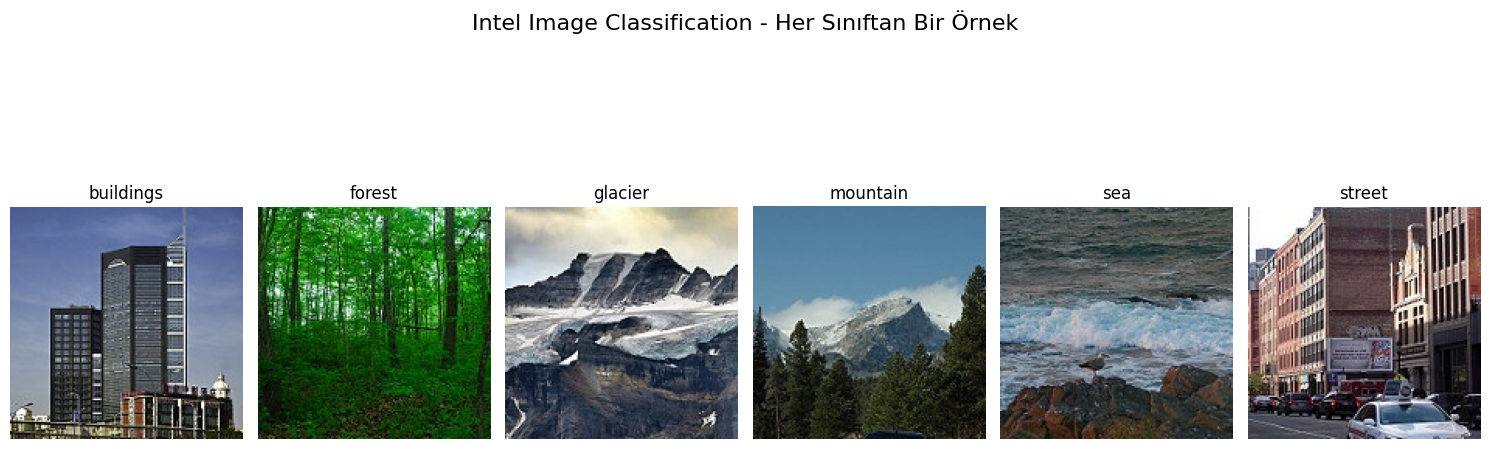

In [4]:
# Her sınıftan bir görseli rastgele seçip gösterelim
class_names = list(train_generator.class_indices.keys())
plt.figure(figsize=(15, 6))
plt.suptitle("Intel Image Classification - Her Sınıftan Bir Örnek", fontsize=16)

for i, class_name in enumerate(class_names):
    class_path = os.path.join(data_dir, class_name)
    all_files = os.listdir(class_path)
    image_files = [f for f in all_files if f.endswith(('.jpg', '.jpeg', '.png'))]
    
    if image_files:
        random_image = random.choice(image_files)
        random_image_path = os.path.join(class_path, random_image)
        
        img = mpimg.imread(random_image_path)
        
        plt.subplot(1, len(class_names), i + 1)
        plt.imshow(img)
        plt.title(class_name, fontsize=12)
        plt.axis('off')

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

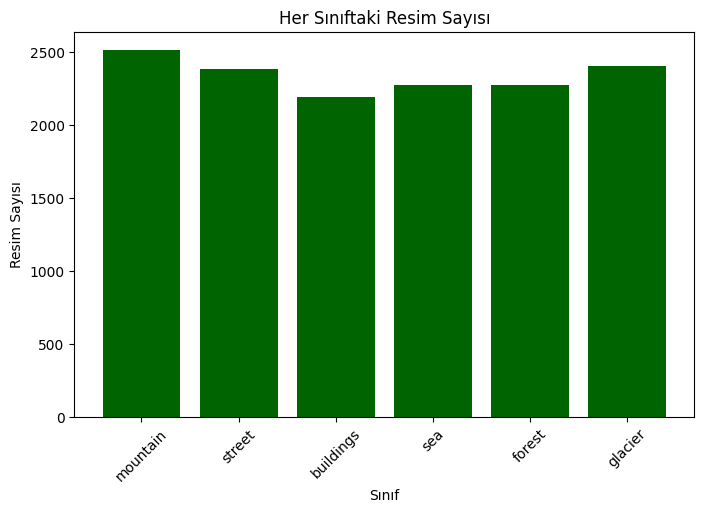

In [5]:
data_dir = "/kaggle/input/intel-image-classification/seg_train/seg_train"

class_counts = {cls: len(os.listdir(os.path.join(data_dir, cls))) 
                for cls in os.listdir(data_dir)}

plt.figure(figsize=(8, 5))
plt.bar(class_counts.keys(), class_counts.values(), color="darkgreen")
plt.title("Her Sınıftaki Resim Sayısı")
plt.xlabel("Sınıf")
plt.ylabel("Resim Sayısı")
plt.xticks(rotation=45)
plt.show()

# CNN Modelinin Oluşturulması ve Derlenmesi
Bu hücrede, temel bir CNN mimarisi oluşturuyoruz:
* Model, 3 adet **Conv2D** ve **MaxPooling2D** bloğundan oluşur. Bu bloklar, görüntülerdeki hiyerarşik özellikleri öğrenir.

* **BatchNormalization**: Her Conv2D katmanından sonra eklenmiştir. Bu, model eğitimini daha kararlı hale getirir ve daha hızlı öğrenmesini sağlar.

* **Flatten katmanı** ile 2D çıktı, 1D vektöre dönüştürülür.

* **Dense katmanı** kararı verirken, Dropout (%50) aşırı öğrenmeyi engeller.

* **activation='relu'**, sinir ağının daha hızlı ve verimli öğrenmesini sağlar, karmaşık problemleri çözmesine yardımcı olur.

* **activation='softmax'**, çok sınıflı sınıflandırma problemlerinde son katmanda kullanılır, çünkü sayısal çıktıları olasılık dağılımına çevirir.

In [6]:
# ---- CNN Modelimiz ----
model = Sequential([
    # İlk konvolüsyon bloğu
    Conv2D(32, (3, 3), activation='relu', input_shape=(img_height, img_width, 3)),
    BatchNormalization(),
    MaxPooling2D((2, 2)),

    # İkinci konvolüsyon bloğu
    Conv2D(64, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    
    # Üçüncü konvolüsyon bloğu 
    Conv2D(128, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    
    # Dördüncü konvolüsyon bloğu
    Conv2D(128, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    
    # Düzleştirme (Flatten) katmanı
    Flatten(),
    
    # (Overfitti azaltmak için Dropout ekledik.)
    Dense(512, activation='relu'),
    Dropout(0.5), 
    
    Dense(256, activation='relu'),
    Dropout(0.5),

    
    Dense(num_classes, activation='softmax')
])

I0000 00:00:1758886369.654032      36 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


**Modelin Derlenmesi (Compiling)**
Bu adım, modelin eğitimi için gerekli olan matematiksel işleyişi (Optimizasyon Algoritması, Kayıp Fonksiyonu ve Metrikler) belirler.
* Adam(lr=0.001), Adam optimizasyon algoritması kullandık. Görüntü sınıflandırması için en yaygın ve etkili seçeneklerden biridir. Burada learning_rate=0.001 ise, modelin ağırlıkları güncellerken atacağı adım büyüklüğünü belirler.
* 'categorical_crossentropy', modelin tahminleri ile gerçek etiketler arasındaki hatayı (kaybı) hesaplamak için kullandık. Sınıflandırma görevlerinde (özellikle One-Hot Encoding formatındaki etiketler için) standart kayıp fonksiyonudur.
* Eğitimin ve doğrulamanın insanlar tarafından okunabilir performansını ölçmek için Doğruluk (Accuracy) metriğini kullandık.

**Eğitim Kontrol Mekanizmaları (Callbacks)**
Eğitim sürecini daha verimli ve kararlı hale getirmek için 3 önemli otomatik araç (callback) tanımlanır:
* ModelCheckpoint, Her epoch sonunda modelin performansını kontrol eder. Doğrulama Doğruluğu (val_accuracy) en yüksek değere ulaştığında, modelin o en iyi halini otomatik olarak intel_image_cnn.h5 dosyasına kaydeder.
* EarlyStopping, Eğer Doğrulama Doğruluğu (val_accuracy) 8 epoch (patience=8) boyunca artmazsa, modelin gereksiz yere eğitime devam etmesini ve aşırı öğrenmesini engellemek için eğitimi erkenden sonlandırır.
* ReduceLROnPlateau, Eğer Doğrulama Kaybı (val_loss) 3 epoch (patience=3) boyunca düşmezse (yani modelin öğrenmesi durursa), Öğrenme Oranını otomatik olarak 5 kat düşürür (factor=0.2). Bu, modelin "platoya" takılıp kalmasını engellemek için ince ayar (fine tunning) yapmasını sağlar.

**Modelin Eğitilmesi (Fitting)**
Son adımda, model.fit() fonksiyonu çağrılarak eğitim başlatılır.

In [7]:
# Modelimizi derliyoruz (compiling)
model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()

# ---- Modeli Eğitme ----
# Gerekli callbacks'leri belirleme
checkpoint_callback = ModelCheckpoint(
    'intel_image_cnn.h5',
    save_best_only=True,
    monitor='val_accuracy',
    mode='max',
    verbose=1
)

early_stopping_callback = EarlyStopping(
    monitor='val_accuracy',
    patience=8, # 8 epoch boyunca doğruluk(accuracy) artmazsa durdur
    mode='max',
    verbose=1
)

# Öğrenme oranını (learning rate) otomatik düşürme
reduce_lr_callback = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.2, 
    patience=3,
    min_lr=0.00001
)

history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // batch_size,
    epochs=30, # Maksimum epoch sayısı
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // batch_size,
    callbacks=[checkpoint_callback, early_stopping_callback, reduce_lr_callback]
)

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 148, 148, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 148, 148, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 74, 74, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 72, 72, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 72, 72, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 36, 36, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 34, 34, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 34, 34, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 17, 17, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 15, 15, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 15, 15, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 7, 7, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 6272)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │     3,211,776 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 6)              │         1,542 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,586,886 (13.68 MB)

 Trainable params: 3,586,182 (13.68 MB)

 Non-trainable params: 704 (2.75 KB)

Epoch 1/30


I0000 00:00:1758886376.731249     118 service.cc:148] XLA service 0x7a5e98004240 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1758886376.732104     118 service.cc:156]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1758886377.327031     118 cuda_dnn.cc:529] Loaded cuDNN version 90300


  1/350 ━━━━━━━━━━━━━━━━━━━━ 1:01:12 11s/step - accuracy: 0.3125 - loss: 3.2275

I0000 00:00:1758886382.045868     118 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


350/350 ━━━━━━━━━━━━━━━━━━━━ 0s 283ms/step - accuracy: 0.4086 - loss: 2.4959
Epoch 1: val_accuracy improved from -inf to 0.17672, saving model to intel_image_cnn.h5
350/350 ━━━━━━━━━━━━━━━━━━━━ 134s 355ms/step - accuracy: 0.4088 - loss: 2.4939 - val_accuracy: 0.1767 - val_loss: 2.6509 - learning_rate: 0.0010
Epoch 2/30
  1/350 ━━━━━━━━━━━━━━━━━━━━ 6s 19ms/step - accuracy: 0.4688 - loss: 1.5243
Epoch 2: val_accuracy improved from 0.17672 to 0.18319, saving model to intel_image_cnn.h5
350/350 ━━━━━━━━━━━━━━━━━━━━ 15s 42ms/step - accuracy: 0.4688 - loss: 1.5243 - val_accuracy: 0.1832 - val_loss: 2.5680 - learning_rate: 0.0010
Epoch 3/30
350/350 ━━━━━━━━━━━━━━━━━━━━ 0s 187ms/step - accuracy: 0.5658 - loss: 1.1574
Epoch 3: val_accuracy improved from 0.18319 to 0.33944, saving model to intel_image_cnn.h5
350/350 ━━━━━━━━━━━━━━━━━━━━ 81s 231ms/step - accuracy: 0.5658 - loss: 1.1572 - val_accuracy: 0.3394 - val_loss: 1.6343 - learning_rate: 0.0010
Epoch 4/30
  1/350 ━━━━━━━━━━━━━━━━━━━━ 5s 17m

# Model Değerlendirmesi ve Raporlama
Bu bölümde, eğitim ve doğrulama süreçlerini grafiklerle analiz ediyor, ardından test verisi üzerinde modelin gerçek performansını ölçüyoruz.

**Başarım ve Kayıp Grafikleri**
Eğitim ve doğrulama başarımları ile kayıplarının (loss) grafiklerini çizerek modelin öğrenme seyrini ve aşırı öğrenme eğilimini gözlemliyoruz.

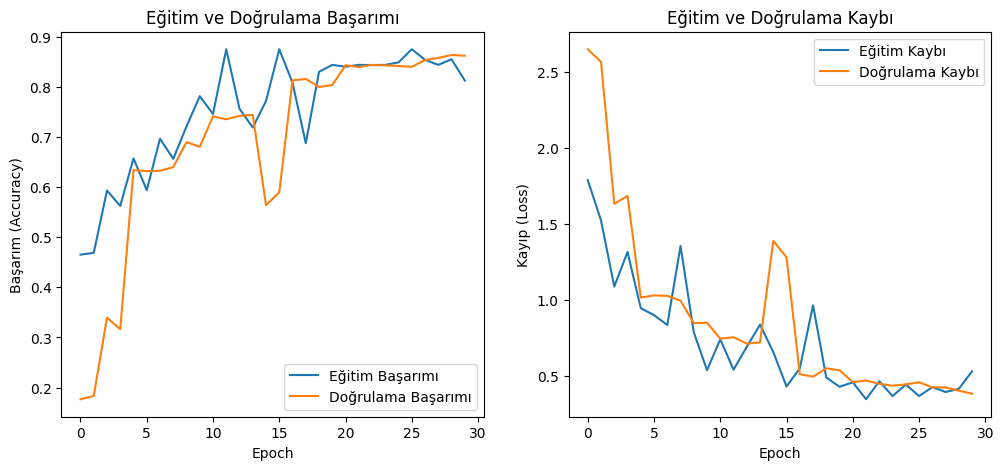

In [8]:
# Başarım ve Kayıp (Loss) Grafikleri
plt.figure(figsize=(12, 5))

# Başarım Grafiği
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Eğitim Başarımı')
plt.plot(history.history['val_accuracy'], label='Doğrulama Başarımı')
plt.title('Eğitim ve Doğrulama Başarımı')
plt.xlabel('Epoch')
plt.ylabel('Başarım (Accuracy)')
plt.legend()

# Kayıp (Loss) Grafiği
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Eğitim Kaybı')
plt.plot(history.history['val_loss'], label='Doğrulama Kaybı')
plt.title('Eğitim ve Doğrulama Kaybı')
plt.xlabel('Epoch')
plt.ylabel('Kayıp (Loss)')
plt.legend()

plt.show()

# Model Değerlendirmesi ve Analiz
**Model Performansı** 
Eğitim ve test sürecinin sonunda, modelimizin genel başarısı ve sınıf bazındaki performansı şu şekilde gözlemlenmiştir:

* **Test Accuracy**: 85.73%

* **Classification Report**:

  * **Buildings**: Precision=0.85, recall=0.84, f1score=0.84
  * **Forest**: Precision=0.91, recall=0.98, f1score=0.94
  * **Glacier**:Precision=0.82, recall=0.78, f1score=0.80
  * **Mountain**:Precision=0.84, recall=0.76, f1score=0.80
  * **Sea**:Precision=0.80, recall=0.89, f1score=0.85
  * **Street**:Precision=0.89, recall=0.86, f1score=0.87

* **Macro Average**: Accuracy=0.85, Precision=0.85, Recall=0.85, F1-Score=0.85
* **Weighted Average**: Accuracy=0.85, Precision=0.85, Recall=0.85, F1-Score=0.86

94/94 ━━━━━━━━━━━━━━━━━━━━ 18s 179ms/step - accuracy: 0.8838 - loss: 0.3436

Test Kaybı: 0.3935
Test Doğruluğu: 0.8620
94/94 ━━━━━━━━━━━━━━━━━━━━ 5s 46ms/step

--- Sınıflandırma Raporu ---
              precision    recall  f1-score   support

   buildings       0.79      0.91      0.85       437
      forest       0.94      0.98      0.96       474
     glacier       0.91      0.73      0.81       553
    mountain       0.82      0.82      0.82       525
         sea       0.82      0.91      0.86       510
      street       0.91      0.85      0.88       501

    accuracy                           0.86      3000
   macro avg       0.86      0.87      0.86      3000
weighted avg       0.87      0.86      0.86      3000



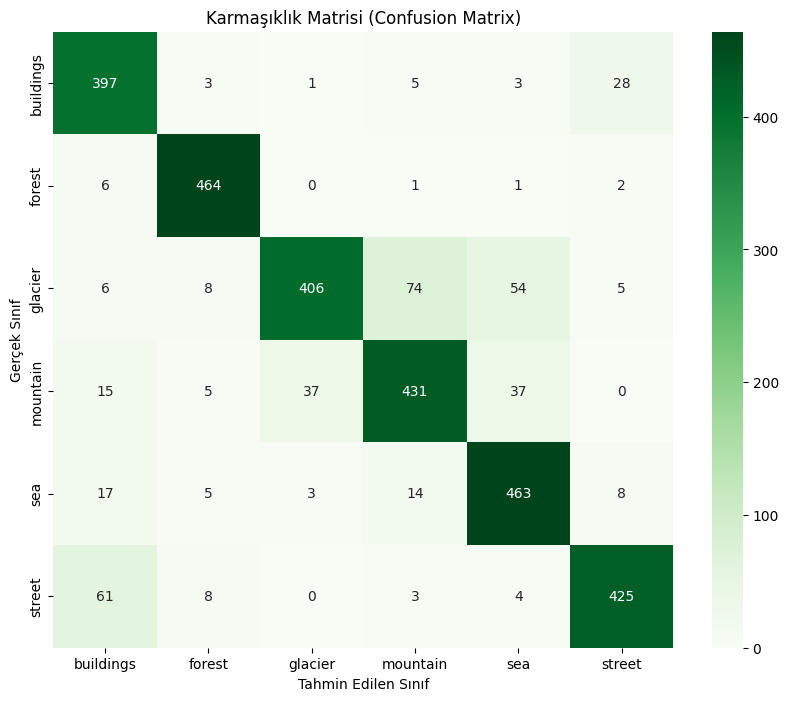

In [9]:
# ---- Model Değerlendirmesi ----
best_model = tf.keras.models.load_model('intel_image_cnn.h5')

# Test verisi üzerinde değerlendirme
loss, acc = best_model.evaluate(test_generator, verbose=1)
print(f'\nTest Kaybı: {loss:.4f}')
print(f'Test Doğruluğu: {acc:.4f}')

# Sınıflandırma raporu için tahminleri al
test_labels = test_generator.classes
y_pred_probs = best_model.predict(test_generator)
y_pred = np.argmax(y_pred_probs, axis=1)

class_labels = list(test_generator.class_indices.keys())

# Sınıflandırma Raporu (Precision, Recall, F1-Score)
print("\n--- Sınıflandırma Raporu ---")
print(classification_report(test_labels, y_pred, target_names=class_labels))

# --- Confusion Matrix Oluşturma ve Görselleştirme ---
cm = confusion_matrix(test_labels, y_pred)

plt.figure(figsize=(10, 8))
sns.heatmap(
    cm, 
    annot=True, 
    fmt='d', 
    cmap='Greens', 
    xticklabels=class_labels, 
    yticklabels=class_labels
)
plt.xlabel('Tahmin Edilen Sınıf')
plt.ylabel('Gerçek Sınıf')
plt.title('Karmaşıklık Matrisi (Confusion Matrix)')
plt.show()

# Grad-CAM Görselleştirme
* Model yükleme & dummy predict — modelin düzgün yüklendiğinden emin olmak için dummy tahmin çalıştırılır.

* Son Conv katmanını bulma — **Conv2D bulunan son katman** tespit edilir.

* Katmanları klonlama ve Functional model inşa etme — orijinal katmanlar, benzersiz adlarla klonlanır; çıktı bir **Lambda** ile sabitlenir; ağırlıklar taşınır.

* **Grad-CAM hesaplama — GradientTape** ile sınıf skoruna göre son konvolüsyon çıktısının gradyanları toplanır, ısı haritası oluşturulur.

* Görselleştirme — OpenCV ile ısı haritası yeniden boyutlandırılır,**test_generator** üzerinden örnek görüntüler alıp her biri için (1) orijinal, (2) ısı haritası, (3) ısı haritası bindirilmiş görüntü şeklinde 3 satırlı bir görselleştirme yapar. renk haritası uygulanır ve görüntüler Matplotlib ile gösterilir.

✅ Model başarıyla yüklendi ve Grad-CAM için hazırlandı.
Orijinal Son Conv katmanı: conv2d_3
Model Functional API yapısına dönüştürüldü
Grad-CAM için kullanılacak yeni Conv katmanı adı: conv2d_3_9


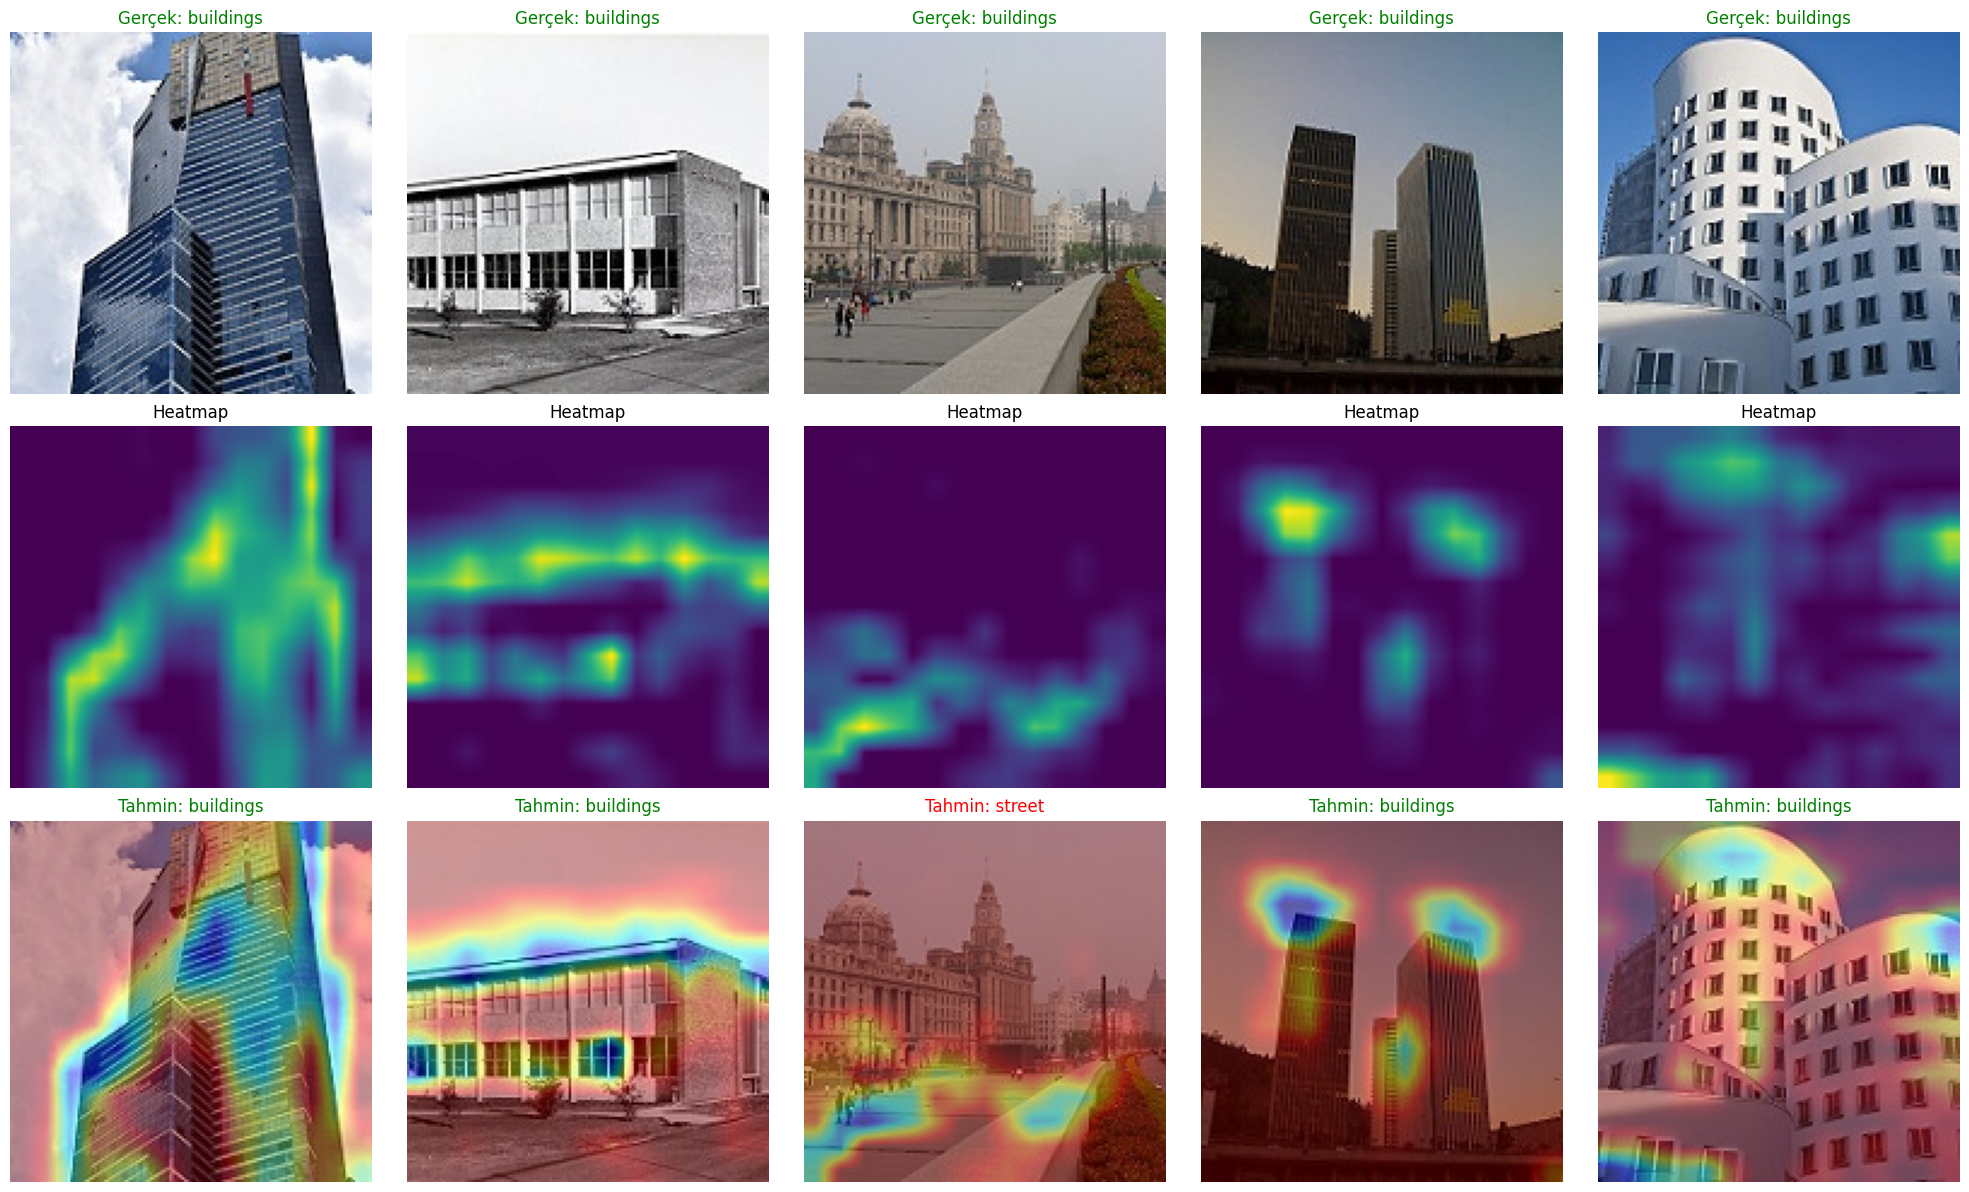

In [10]:
# Proje ayarları
IMG_SIZE = 150 
MODEL_FILE_NAME = 'intel_image_cnn.h5' 

# ----------------------------------------------------
# 1. Model Yükleme ve ZORUNLU İNŞA
# ----------------------------------------------------

try:
    # Orijinal modeli yükle
    best_model = tf.keras.models.load_model(MODEL_FILE_NAME)
    
    # Modelin Functional API için hazırlanmasını garantilemek amacıyla
    input_shape = (None, IMG_SIZE, IMG_SIZE, 3) 
    best_model.build(input_shape=input_shape)
    
    # Modelin çağrılmasını zorlamak için dummy tahmin yap
    dummy_input = np.zeros((1, IMG_SIZE, IMG_SIZE, 3), dtype=np.float32)
    _ = best_model.predict(dummy_input, verbose=0)
    
    print(f"✅ Model başarıyla yüklendi ve Grad-CAM için hazırlandı.")
except FileNotFoundError:
    print(f"❌ HATA: '{MODEL_FILE_NAME}' dosyası bulunamadı. Lütfen dosya adını ve yolunu kontrol edin.")
    raise 

# ----------------------------------------------------
# 2. Son Evrişim Katmanını Dinamik Olarak Bulma ve Modeli Functional API'ye DÖNÜŞTÜRME
# ----------------------------------------------------
last_conv_layer_name = None
for layer in reversed(best_model.layers):
    if isinstance(layer, tf.keras.layers.Conv2D):
        last_conv_layer_name = layer.name; break
        
if not last_conv_layer_name:
    print("HATA: Modelde hiç Conv2D katmanı bulunamadı.")
    raise ValueError
    
print(f"Orijinal Son Conv katmanı: {last_conv_layer_name}")

input_layer = tf.keras.Input(shape=(IMG_SIZE, IMG_SIZE, 3))
x = input_layer
new_last_conv_layer_name = None

# Orijinal modelin tüm operasyonel katmanlarını kopyala
for i, layer in enumerate(best_model.layers): 
    if isinstance(layer, tf.keras.layers.InputLayer):
        continue

    new_name = f"{layer.name}_{i}" 
    
    layer_config = layer.get_config()
    layer_config['name'] = new_name # Yeni, benzersiz ismi config'e ata
    
    # Klonlanmış katmanı oluştur ve bağla
    cloned_layer = layer.__class__.from_config(layer_config)
    x = cloned_layer(x)
    
    # Eğer bu, orijinal son conv katmanının adıysa, yeni adını kaydet
    if layer.name == last_conv_layer_name:
        new_last_conv_layer_name = new_name

# Lambda katmanı ekleyerek çıktı tensor kimliğini kesinleştirir
output_layer_tensor = Lambda(lambda z: z, name='final_output_fix')(x)

# Yeni Functional API modelini oluştur ve ağırlıkları aktar
fixed_model = Model(inputs=input_layer, outputs=output_layer_tensor)
fixed_model.set_weights(best_model.get_weights()) 
fixed_model.compile(optimizer='adam', loss='categorical_crossentropy') 

best_model = fixed_model # Tüm kod bu yeni, stabil modeli kullanmaya devam edecek
last_conv_layer_name = new_last_conv_layer_name # Yeni, benzersiz ismi kullan
print("Model Functional API yapısına dönüştürüldü")
print(f"Grad-CAM için kullanılacak yeni Conv katmanı adı: {last_conv_layer_name}")

# ----------------------------------------------------
# 3. Grad-CAM Fonksiyonu
# ----------------------------------------------------

def make_gradcam_heatmap_functional(img_array, model, last_conv_layer_name):
    grad_model = Model(
        model.inputs, 
        [
            model.get_layer(last_conv_layer_name).output, 
            model.get_layer('final_output_fix').output 
        ]
    )
    
    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]
        
    grads = tape.gradient(class_channel, last_conv_layer_output)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)
    heatmap = tf.maximum(heatmap, 0) / (tf.math.reduce_max(heatmap) + 1e-8)
    return heatmap.numpy()

# ----------------------------------------------------
# 4. Veri Alma ve Görselleştirme Döngüsü
# ----------------------------------------------------
test_generator.reset()
num_samples_to_visualize = 5
sample_images, sample_labels_one_hot = [], []

# test_generator'dan 5 örnek al
for _ in range(num_samples_to_visualize):
    try:
        img_batch, label_batch = next(test_generator)
        sample_images.append(img_batch[0])
        sample_labels_one_hot.append(label_batch[0])
    except StopIteration:
        print("Test generator'ı sona ulaştı.")
        break

sample_images = np.array(sample_images)
sample_labels = np.argmax(np.array(sample_labels_one_hot), axis=1)
class_labels = list(test_generator.class_indices.keys())

plt.figure(figsize=(20, 12))
for i in range(num_samples_to_visualize):
    original_image = sample_images[i]
    img_array_for_model = np.expand_dims(original_image, axis=0) 
    
    # Isı haritasını hesapla
    heatmap = make_gradcam_heatmap_functional(img_array_for_model, best_model, last_conv_layer_name)
    
    # Görselleştirme için 0-255 aralığında rescale et
    img_uint8 = (original_image * 255).astype(np.uint8) 
    
    # Isı haritasını OpenCV ile boyutlandır ve bindir
    heatmap_resized = cv2.resize(heatmap, (img_uint8.shape[1], img_uint8.shape[0]))
    heatmap_color = np.uint8(255 * heatmap_resized)
    heatmap_color = cv2.applyColorMap(heatmap_color, cv2.COLORMAP_JET)
    superimposed_image = cv2.addWeighted(img_uint8, 0.6, heatmap_color, 0.4, 0)

    # Tahmin yap
    prediction = best_model.predict(img_array_for_model, verbose=0) 
    predicted_label = class_labels[np.argmax(prediction)]
    true_label = class_labels[sample_labels[i]]

    # 1. Satır: Orijinal Resim
    plt.subplot(3, num_samples_to_visualize, i + 1)
    plt.imshow(original_image); 
    plt.title(f"Gerçek: {true_label}", color='green'); 
    plt.axis('off')

    # 2. Satır: Isı Haritası
    plt.subplot(3, num_samples_to_visualize, i + num_samples_to_visualize + 1)
    plt.imshow(heatmap_resized, cmap='viridis'); 
    plt.title("Heatmap"); 
    plt.axis('off')

    # 3. Satır: Bindirilmiş Resim ve Tahmin
    plt.subplot(3, num_samples_to_visualize, i + 2*num_samples_to_visualize + 1)
    title_color = 'green' if true_label == predicted_label else 'red'
    plt.imshow(superimposed_image); 
    plt.title(f"Tahmin: {predicted_label}", color=title_color); 
    plt.axis('off')

plt.tight_layout()
plt.show()

## 🔧 Hiperparametre Optimizasyonu (Keras Tuner ile)

Bu bölümde modelin performansını artırmak için **Keras Tuner** kullanılarak hiperparametre araması yapılmıştır.  

### 📌 Denenen Hiperparametreler
- **Conv2D filtre sayıları:** `[32, 64, 128, 256]`  
- **Dense katman ünite sayıları:** `[128, 256, 512]`  
- **Dropout oranları:** `0.3 – 0.6` arası  
- **Learning Rate (öğrenme oranı):** `1e-4 – 1e-2` arası (log ölçeğinde)  

### ⚙️ Yöntem
- **Random Search Tuner** kullanılmıştır.  
- Maksimum `10 deneme (trials)` yapılmış, her deneme farklı hiperparametre kombinasyonunu test etmiştir.  
- **Callback’ler:**  
  - `EarlyStopping`: Overfitting’i önlemek için validation accuracy gözlemlenmiştir.  
  - `ModelCheckpoint`: En iyi modeli kaydetmek için kullanılmıştır.  

### 📊 Sonuçlar
- En iyi hiperparametre kombinasyonu çıktı olarak alınmıştır.  
- Bu hiperparametreler ile model tekrar eğitilmiştir.  
- Son olarak test seti üzerinde doğruluk değeri hesaplanmıştır.
- Burada 1024 kombinasyondan sadece 10 tanesi alınmış ve denenmiştir daha büyük bir gpuda daha iyi sonuçlar verecektir.
    




In [11]:
!pip install -q keras-tuner

import keras_tuner as kt
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization

# --- Modeli oluşturma fonksiyonu (tuner için) ---
def build_model(hp):
    model = Sequential([
        # İlk konvolüsyon bloğu
        Conv2D(hp.Choice('filters_1', [32, 64]), (3, 3), activation='relu', input_shape=(img_height, img_width, 3)),
        BatchNormalization(),
        MaxPooling2D((2, 2)),

        # İkinci konvolüsyon bloğu
        Conv2D(hp.Choice('filters_2', [64, 128]), (3, 3), activation='relu'),
        BatchNormalization(),
        MaxPooling2D((2, 2)),

        # Üçüncü konvolüsyon bloğu
        Conv2D(hp.Choice('filters_3', [128, 256]), (3, 3), activation='relu'),
        BatchNormalization(),
        MaxPooling2D((2, 2)),

        # Dördüncü konvolüsyon bloğu
        Conv2D(hp.Choice('filters_4', [128, 256]), (3, 3), activation='relu'),
        BatchNormalization(),
        MaxPooling2D((2, 2)),

        Flatten(),

        Dense(hp.Choice('dense_units_1', [256, 512]), activation='relu'),
        Dropout(hp.Float('dropout_1', 0.3, 0.6, step=0.1)),

        Dense(hp.Choice('dense_units_2', [128, 256]), activation='relu'),
        Dropout(hp.Float('dropout_2', 0.3, 0.6, step=0.1)),

        Dense(num_classes, activation='softmax')
    ])

    # Öğrenme oranı araması
    lr = hp.Float('learning_rate', 1e-4, 1e-2, sampling='log')

    model.compile(
        optimizer=Adam(learning_rate=lr),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    return model

# --- Random Search Tuner ---
tuner = kt.RandomSearch(
    build_model,
    objective='val_accuracy',
    max_trials=10,          # Denenecek farklı hiperparametre kombinasyonu sayısı
    executions_per_trial=1, # Her kombinasyonu 1 defa dener
    directory='kt_random_dir',
    project_name='intel_cnn_random_search'
)

# --- Callback'ler ---
early_stopping = EarlyStopping(monitor='val_accuracy', patience=5, restore_best_weights=True)
checkpoint = ModelCheckpoint('intel_image_cnn_tuned.h5', save_best_only=True, monitor='val_accuracy', mode='max')

# --- Arama işlemi ---
tuner.search(
    train_generator,
    epochs=15,
    validation_data=validation_generator,
    callbacks=[early_stopping, checkpoint]
)

# --- En iyi hiperparametreleri al ---
best_hp = tuner.get_best_hyperparameters(1)[0]
print("📌 En iyi hiperparametreler:")
for param, value in best_hp.values.items():
    print(f"{param}: {value}")

# --- En iyi modeli eğit ---
best_model = tuner.hypermodel.build(best_hp)
history = best_model.fit(
    train_generator,
    epochs=30,
    validation_data=validation_generator,
    callbacks=[early_stopping, checkpoint]
)

# --- Test değerlendirmesi ---
loss, acc = best_model.evaluate(test_generator)
print(f"✅ Test doğruluğu: {acc:.4f}")


Trial 10 Complete [00h 19m 36s]
val_accuracy: 0.804921567440033

Best val_accuracy So Far: 0.8484308123588562
Total elapsed time: 02h 56m 43s
📌 En iyi hiperparametreler:
filters_1: 64
filters_2: 64
filters_3: 256
filters_4: 128
dense_units_1: 512
dropout_1: 0.3
dense_units_2: 256
dropout_2: 0.5
learning_rate: 0.00035808598204138133
Epoch 1/30
351/351 ━━━━━━━━━━━━━━━━━━━━ 88s 228ms/step - accuracy: 0.4777 - loss: 1.6937 - val_accuracy: 0.2044 - val_loss: 2.8065
Epoch 2/30
351/351 ━━━━━━━━━━━━━━━━━━━━ 76s 216ms/step - accuracy: 0.6510 - loss: 0.9604 - val_accuracy: 0.6680 - val_loss: 0.8331
Epoch 3/30
351/351 ━━━━━━━━━━━━━━━━━━━━ 75s 214ms/step - accuracy: 0.7121 - loss: 0.7903 - val_accuracy: 0.6534 - val_loss: 0.9794
Epoch 4/30
351/351 ━━━━━━━━━━━━━━━━━━━━ 77s 221ms/step - accuracy: 0.7403 - loss: 0.7208 - val_accuracy: 0.6480 - val_loss: 0.8551
Epoch 5/30
351/351 ━━━━━━━━━━━━━━━━━━━━ 81s 230ms/step - accuracy: 0.7631 - loss: 0.6828 - val_accuracy: 0.7621 - val_loss: 0.6471
Epoch 6/30
